**TASK: IMPORT THE BASIC LIBRARIES YOU THINK YOU WILL USE**

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pandas'

## Data

We'll use the standard airline passengers dataset

In [2]:
# CODE HERE

<AxesSubplot:xlabel='Month'>

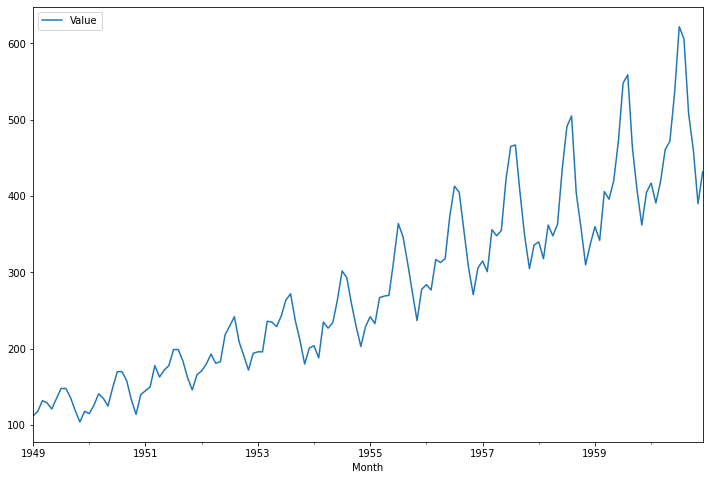

In [3]:
df = pd.read_csv('../../data/airline_passengers.csv',index_col='Month',parse_dates=True)
df.columns = ['Value']
df.plot(figsize=(12,8))

# Problem 1: `Figure out Train/Test Split`
Compute the length of the dataset & then split it into train/test dataframes where the test set is the last 12 months of data

**TASK: Split the data into a train/test split where the test set is the last 12 months of data.**

In [4]:
train_len = len(df)-12
train = df.iloc[:train_len]
test = df.iloc[train_len:]

# Problem 2:  `Scale Data`
Use a `MinMaxScaler` to appropriate scale the train and test sets into scaled versions

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Note how we only fit on the training data here
scaler.fit(train)

MinMaxScaler()

In [6]:
#Use the parameters found from fitting just on train, we transform (i.e. actually scale) both the train & test sets
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Problem 3: `Time Series Generator`

Create a TimeSeriesGenerator object based off the scaled_train data using 12 months of lagged inputs

In [8]:
from keras.preprocessing.sequence import TimeseriesGenerator
n_lagged_inputs = 12
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_lagged_inputs, batch_size=1)

In [9]:
scaled_train.shape

(132, 1)

In [10]:
def custom_ts_univariate_data_prep(dataset, start, end, window, horizon):
  X = []
  y = []

  start = start + window
  if end is None:
    end = len(dataset) - horizon

  for i in range(start, end):
    indicesx = range(i-window, i)
    X.append(np.reshape(dataset[indicesx], (window, 1)))
    indicesy = range(i,i+horizon)
    y.append(dataset[indicesy])
  return np.array(X), np.array(y)

# Problem 4 `Custom TS Prep`
Using the the `custom_ts_univariate_data_prep` function we applied during the lecture, show how it's first batch of X and y are equivalent to the ones produced by Keras's `TimeseriesGenerator`

In [11]:
X,y = custom_ts_univariate_data_prep(scaled_train,0,scaled_train.shape[0],n_lagged_inputs,1)

In [12]:
print(X[0])
print(y[0])

[[0.01758242]
 [0.03076923]
 [0.06153846]
 [0.05494505]
 [0.03736264]
 [0.06813187]
 [0.0967033 ]
 [0.0967033 ]
 [0.07032967]
 [0.03296703]
 [0.        ]
 [0.03076923]]
[[0.02417582]]


In [13]:
x0,y0 = generator[0]
print(x0)
print(y0)

[[[0.01758242]
  [0.03076923]
  [0.06153846]
  [0.05494505]
  [0.03736264]
  [0.06813187]
  [0.0967033 ]
  [0.0967033 ]
  [0.07032967]
  [0.03296703]
  [0.        ]
  [0.03076923]]]
[[0.02417582]]


# Problem 5:  `Create the Model`

Create a Keras Sequential Model with as many LSTM units you want and a final Dense Layer.  Display the model summary after compliling it

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_lagged_inputs, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


# Problem 6: `Fit the Model`
Train the created model by using the generator.  Use as many epochs as you have patience for

In [15]:
# fit model
model.fit_generator(generator,epochs=30)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
120/120 [==============================] - 1s 8ms/step - loss: 0.0279
Epoch 2/30
120/120 [==============================] - 1s 8ms/step - loss: 0.0124
Epoch 3/30
120/120 [==============================] - 1s 8ms/step - loss: 0.0122
Epoch 4/30
120/120 [==============================] - 1s 8ms/step - loss: 0.0105
Epoch 5/30
120/120 [==============================] - 1s 8ms/step - loss: 0.0087
Epoch 6/30
120/120 [==============================] - 1s 8ms/step - loss: 0.0111
Epoch 7/30
120/120 [==============================] - 1s 8ms/step - loss: 0.0108
Epoch 8/30
120/120 [==============================] - 1s 8ms/step - loss: 0.0065
Epoch 9/30
120/120 [==============================] - 1s 8ms/step - loss: 0.0065
Epoch 10/30
120/120 [==============================] - 1s 8ms/step - loss: 0.0051
Epoch 11/30
120/120 [==============================] - 1s 8ms/step - loss: 0.0050
Epoch 12/30
120/120 [==========

# Problem 6 `Plot history of loss during training`

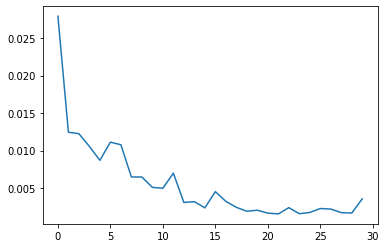

In [16]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

# Problem 7  `Evaluate on Test Data`
Reshape the following `first_eval_batch` into a shape suitable for applying model predictions upon

In [38]:
first_eval_batch = scaled_train[-n_lagged_inputs:]
current_batch = first_eval_batch.reshape((1, n_lagged_inputs, n_features))

# Problem 8: `Generate Predictions`
Using your reshaping above, generate predictions into the same timestamps as the test set

In [39]:
test_predictions = []
for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

# Problem 8: `Inverse Transform`
Using our previously fit `scaler` inversely transform the test predictions back into original scale & add a new column called `Predictions` to our `test` DataFrame

In [40]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test

<ipython-input-40-81ff6aecbb8e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


,Value,Predictions
Month,,
1960-01-01,417,387.261258
1960-02-01,391,391.437620
1960-03-01,419,418.439192
1960-04-01,461,434.688696
1960-05-01,472,468.035153
1960-06-01,535,530.294174
1960-07-01,622,599.986031
1960-08-01,606,603.884927
1960-09-01,508,519.395359


# Problem 9: `Plot out the test set against the predictions`

<AxesSubplot:xlabel='Month'>

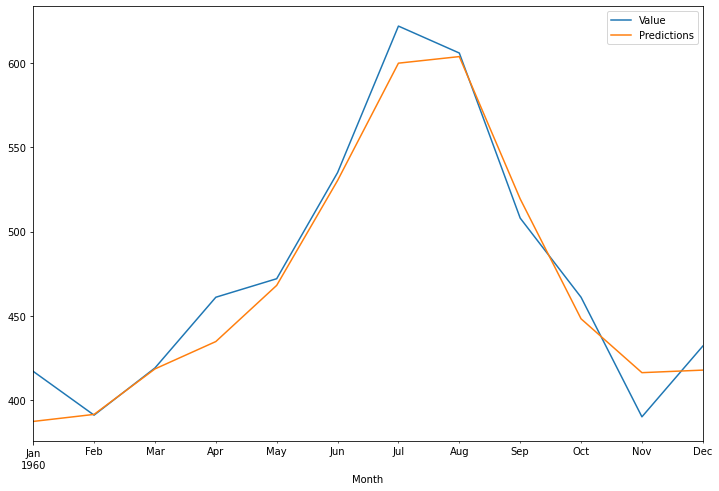

In [41]:
test.plot(figsize=(12,8))